In [15]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import string
import json

In [16]:
with open("numeric_phones.json") as f:
    numeric_phones = json.load(f)
    
mapper = {a: i for i, a in zip(range(32), string.ascii_lowercase + string.ascii_uppercase)}

In [17]:
def translator(character):
    character = character.replace(" ; ", "").replace(" ", "").replace("<eps>", "")
    index = int(character)
    
    if index == 0:
        return "silence"
    
    for phone, i in numeric_phones.items():
        if i == index:
            return phone        

In [18]:
with open("bref/cer_test_15_epochs.txt") as f:
    lines = [line.replace("\n", "") for line in f.readlines()]

In [19]:
true_labels = np.array([translator(value) for value in lines[13::5]])
predicted_labels = np.array([translator(value) for value in lines[15::5]])

# Remove silences
silence_indexes = np.where(true_labels == "silence")[0]
true_labels_no_sil = np.delete(true_labels, silence_indexes)
predicted_labels_no_sil = np.delete(predicted_labels, silence_indexes)

with open("phones.json") as f:
    phones = json.load(f)

# Replacing the silence predicted by a random different phone
for i, ph in enumerate(predicted_labels_no_sil):
    if ph == "silence":
        for sub_ph in ["aa", "bb"]:
            if sub_ph != true_labels_no_sil[i]:
                predicted_labels_no_sil[i] = sub_ph
                break

print("Accuracy:", accuracy_score([phones[a] for a in true_labels_no_sil], [phones[a] for a in predicted_labels_no_sil]))
print("Balanced accuracy:", balanced_accuracy_score([phones[a] for a in true_labels_no_sil], [phones[a] for a in predicted_labels_no_sil]))

Accuracy: 0.8334977683814893
Balanced accuracy: 0.8349589207373496


In [20]:
def compute_confusion_matrix(true, predicted):
    label_names_existing = list(set(true))
    label_names_organized = ['silence', 'aa', 'ai', 'ei', 'ee', 'au', 'ou', 'uu', 'ii', 'an', 'on', 'un', 'ww', 'uy',
                             'yy', 'll', 'rr', 'nn', 'mm', 'gn', 'pp', 'tt', 'kk', 'bb', 'dd', 'gg', 'ff', 'ss', 'ch',
                             'vv', 'zz', 'jj']
    
    label_names_existing = list(set([phones[a] for a in true]))
    label_names_organized = ["sil", "a", "Ê", "Û", "Ô", "u", "y", "i", "ã", "ɔ̃", "µ", "w", "ɥ", "j", "l", "ʁ", "n", "m", "ɲ", "p", "t", "k", "b", "d", "g", "f", "s", "ʃ", "v", "z", "ʒ"]
    
    cm = confusion_matrix([phones[a] for a in true], [phones[a] for a in predicted], normalize="true")
    
    # Use the specified labels order to link current cm layout to organized layout
    new_order = [label_names_existing.index(label) for label in label_names_organized if label in label_names_existing]
    cm = cm[:, new_order][new_order, :]

    # Adding lines for phonemes that were not present in the input audio
    for i in range(len(label_names_organized)):
        if label_names_organized[i] not in label_names_existing:
            cm = np.insert(cm, i, 0.0, axis=1)
            cm = np.insert(cm, i, 0.0, axis=0)

    # Set 0 lines to NaN
    for i in range(cm.shape[0]):
        if np.count_nonzero(cm[i, :]) == 0:
            cm[i, :] = np.nan
            
    return cm

In [21]:
import itertools


def plot_confusion_matrix(cm, savefig=True, file='', cmap=plt.cm.pink_r):
    label_names_organized_phonetic = ["sil", "a", "Ê", "Û", "Ô", "u", "y", "i", "ã", "ɔ̃", "µ", "w", "ɥ", "j", "l", "ʁ", "n", "m", "ɲ", "p", "t", "k", "b", "d", "g", "f", "s", "ʃ", "v", "z", "ʒ"]
    
    fig, ax = plt.subplots(dpi=125)
    fig.set_size_inches(15, 12, forward=True)
    
    rect = plt.Rectangle((-0.5, -0.5), cm.shape[1], cm.shape[0], linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(rect)

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    ax.set_title(file, fontsize=20)
    plt.colorbar(im, ax=ax)

    tick_marks = np.arange(len(label_names_organized_phonetic))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels([f"/{a}/" for a in label_names_organized_phonetic], fontsize=14)
    ax.set_yticklabels([f"/{a}/" for a in label_names_organized_phonetic], fontsize=14)
    
    ax.grid(False)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > 0.6 else "black"
        ax.text(j, i, f'{cm[i, j] * 100:.1f}',
                ha="center", va="center", color=color, fontsize=10)

    plt.tight_layout(pad=3)
    ax.set_ylabel('True labels', fontsize=18)
    ax.set_xlabel('Predicted labels', fontsize=18)

    if savefig:
        plt.savefig(f"{file}_confusion_matrix.png", bbox_inches='tight', pad_inches=0.1)
        print(f"Confusion matrix was saved at confusion_matrix.png")

Confusion matrix was saved at confusion_matrix.png


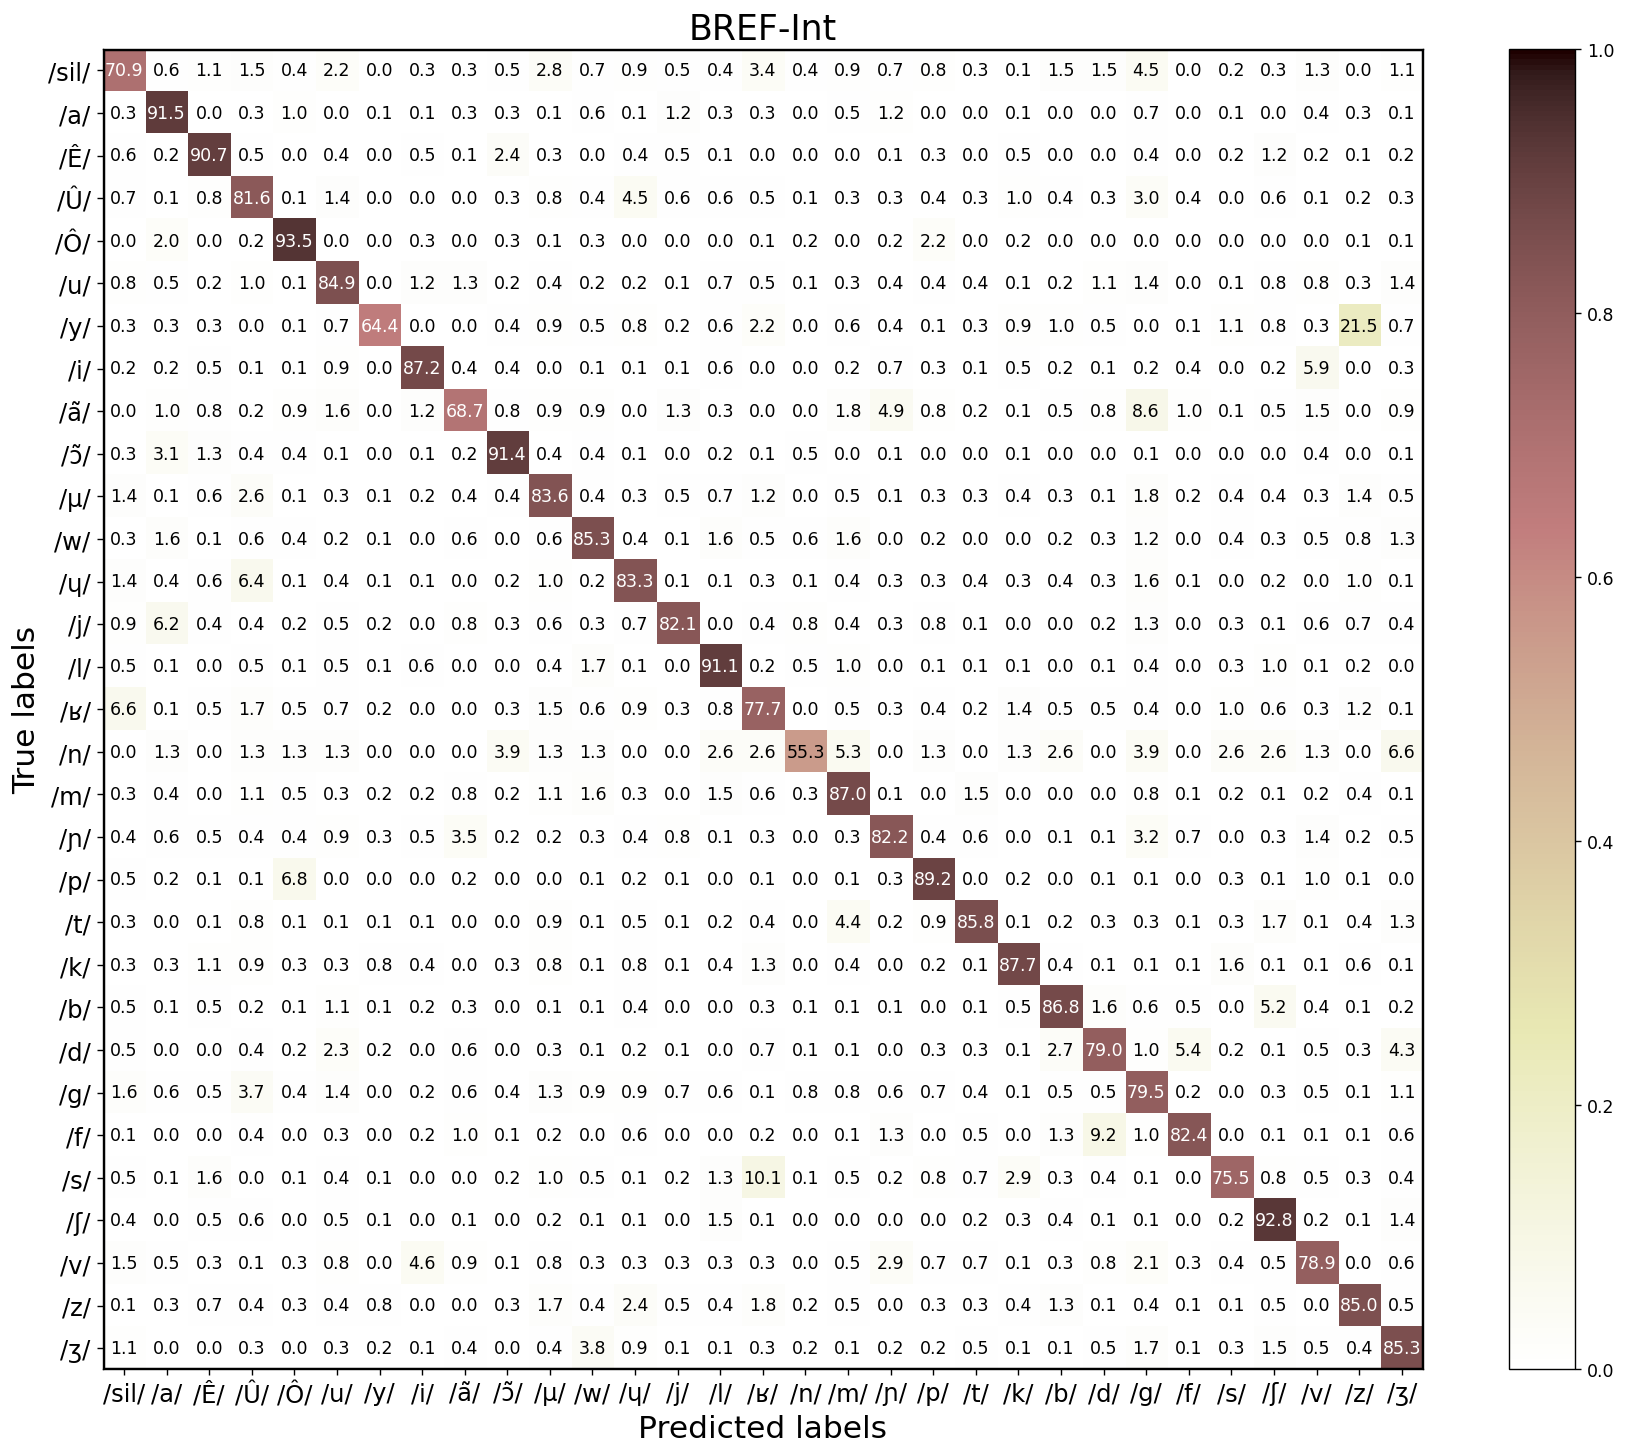

In [22]:
plot_confusion_matrix(compute_confusion_matrix(true_labels, predicted_labels), file="BREF-Int")